In [3]:
import glob
from os.path import join, expanduser
import xarray as xr
import dask
import numpy as np
import pandas as pd
from pathlib import Path
import intake
import cftime
import datetime as dt
from dask.distributed import Client
from dask_jobqueue import PBSCluster


## Find your files:

In [4]:
sim_path = "/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/" 
variable = "PRECT"
sim_files = sorted(glob.glob(join(sim_path,variable,"b.e21.BHISTsmbb.f09_g17.LE2-1301*.nc")))

# How many files?
print (len(sim_files))
print("\n".join(sim_files))


170
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18500101-18591231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18600101-18691231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18700101-18791231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18800101-18891231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.18900101-18991231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.19000101-19091231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/PRECT/b.e21.BHISTsmbb.f09_g17.LE2-1301.011.cam.h1.PRECT.19100101-19191231.nc
/glade/campaign/cgd/cesm/CESM2-LE/atm/proc/tseries/day_1/P

## Using Dask: 
Let's scale everything up using Dask.

In [3]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk23-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '30:00',
    interface = 'ext'
)

In [4]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/Backup/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/Backup/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:44081,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/Backup/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
num_workers = 64 
cluster.scale(num_workers)

#client.wait_for_workers(num_workers)

In [9]:
!qstat -u $USER

                                                            Req'd  Req'd   Elap
Job ID          Username Queue    Jobname    SessID NDS TSK Memory Time  S Time
--------------- -------- -------- ---------- ------ --- --- ------ ----- - -----
1276801.casper* negins   jhublog* cr-login-*  46195   1   1    4gb 720:0 R 03:38
1277916.casper* negins   htc      STDIN       18839   1   1   32gb 02:00 R 00:05
1277987.casper* negins   htc      dask-wk23*  34216   1   1    4gb 00:30 R 00:00
1277988.casper* negins   htc      dask-wk23*  34279   1   1    4gb 00:30 R 00:00
1277989.casper* negins   htc      dask-wk23*  34338   1   1    4gb 00:30 R 00:00
1277990.casper* negins   htc      dask-wk23*  34399   1   1    4gb 00:30 R 00:00
1277991.casper* negins   htc      dask-wk23*  34462   1   1    4gb 00:30 R 00:00
1277992.casper* negins   htc      dask-wk23*  34527   1   1    4gb 00:30 R 00:00
1277993.casper* negins   htc      dask-wk23*  34599   1   1    4gb 00:30 R 00:00
1277994.casper* negins   htc  

## Read in all Files: 

In [12]:
%%time
ds = xr.open_mfdataset(
    sorted(sim_files),
    # concatenate files in the order provided
    combine="by_coords",
    # parallelize the reading of individual files using dask
    # This means the returned arrays will be dask arrays
    parallel=True,
    # these are netCDF4 files, use the h5netcdf package to read them
    engine="h5netcdf",
    # hold off on decoding time
    decode_cf=False,
    # specify that data should be automatically chunked
    chunks="auto",
)



CPU times: user 1.36 s, sys: 53.9 ms, total: 1.41 s
Wall time: 2.52 s


In [13]:
%%time
# decode cftime ## not required with newer Xr version
ds = xr.decode_cf(ds)
ds

CPU times: user 435 ms, sys: 16 ms, total: 451 ms
Wall time: 872 ms


<xarray.Dataset> Size: 13GB
Dimensions:       (lat: 192, lon: 288, time: 60226, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * lat           (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon           (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time          (time) object 482kB 1850-01-01 00:00:00 ... 2015-01-01 00:0...
Dimensions without coordinates: nbnd
Data variables: (12/26)
    gw            (time, lat) float64 93MB dask.array<chunksize=(3650, 192), meta=np.ndarray>
    hyam          (time, lev) float64 15MB dask.array<chunksize=(3650, 32), meta=np.ndarray>
    hybm          (time, lev) float64 15MB dask.array<chunksize=(3650, 32), meta=np.ndarray>
    P0            (time) float64 482kB ...
    hyai          (time, ilev) float64 16MB dask.array<chunksize=(3650, 33), meta=np.ndarray>
    hybi          (time, ilev) float64 16MB dask.array<chunksize=(3650, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 482kB dask.array<chunksize=(3650,), meta=np.ndarray>
    f11vmr        (time) float64 482kB dask.array<chunksize=(3650,), meta=np.ndarray>
    f12vmr        (time) float64 482kB dask.array<chunksize=(3650,), meta=np.ndarray>
    sol_tsi       (time) float64 482kB dask.array<chunksize=(3650,), meta=np.ndarray>
    nsteph        (time) int32 241kB dask.array<chunksize=(3650,), meta=np.ndarray>
    PRECT         (time, lat, lon) float32 13GB dask.array<chunksize=(606, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTsmbb.f09_g17.LE2-1301.020
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1301-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

In [14]:
precip = ds.PRECT
precip

<xarray.DataArray 'PRECT' (time: 60226, lat: 192, lon: 288)> Size: 13GB
dask.array<concatenate, shape=(60226, 192, 288), dtype=float32, chunksize=(606, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 482kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

## Calculate Maximum Precip Per Year

In [16]:
## calculate annual maximum: 

max_precip = precip.groupby(precip.time.dt.year).max()
max_precip

<xarray.DataArray 'PRECT' (year: 166, lat: 192, lon: 288)> Size: 37MB
dask.array<transpose, shape=(166, 192, 288), dtype=float32, chunksize=(3, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2012 2013 2014 2015
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

### Plot Data for 1 Year

CPU times: user 99.3 ms, sys: 13.3 ms, total: 113 ms
Wall time: 1.48 s


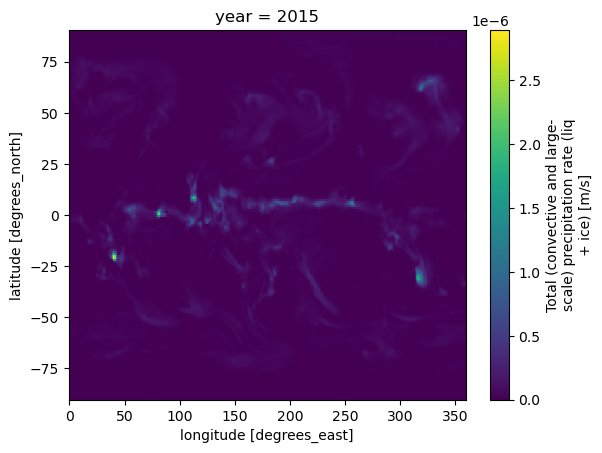

In [21]:
%%time
max_precip.sel(year=2015).plot()

## Low-level computate graph

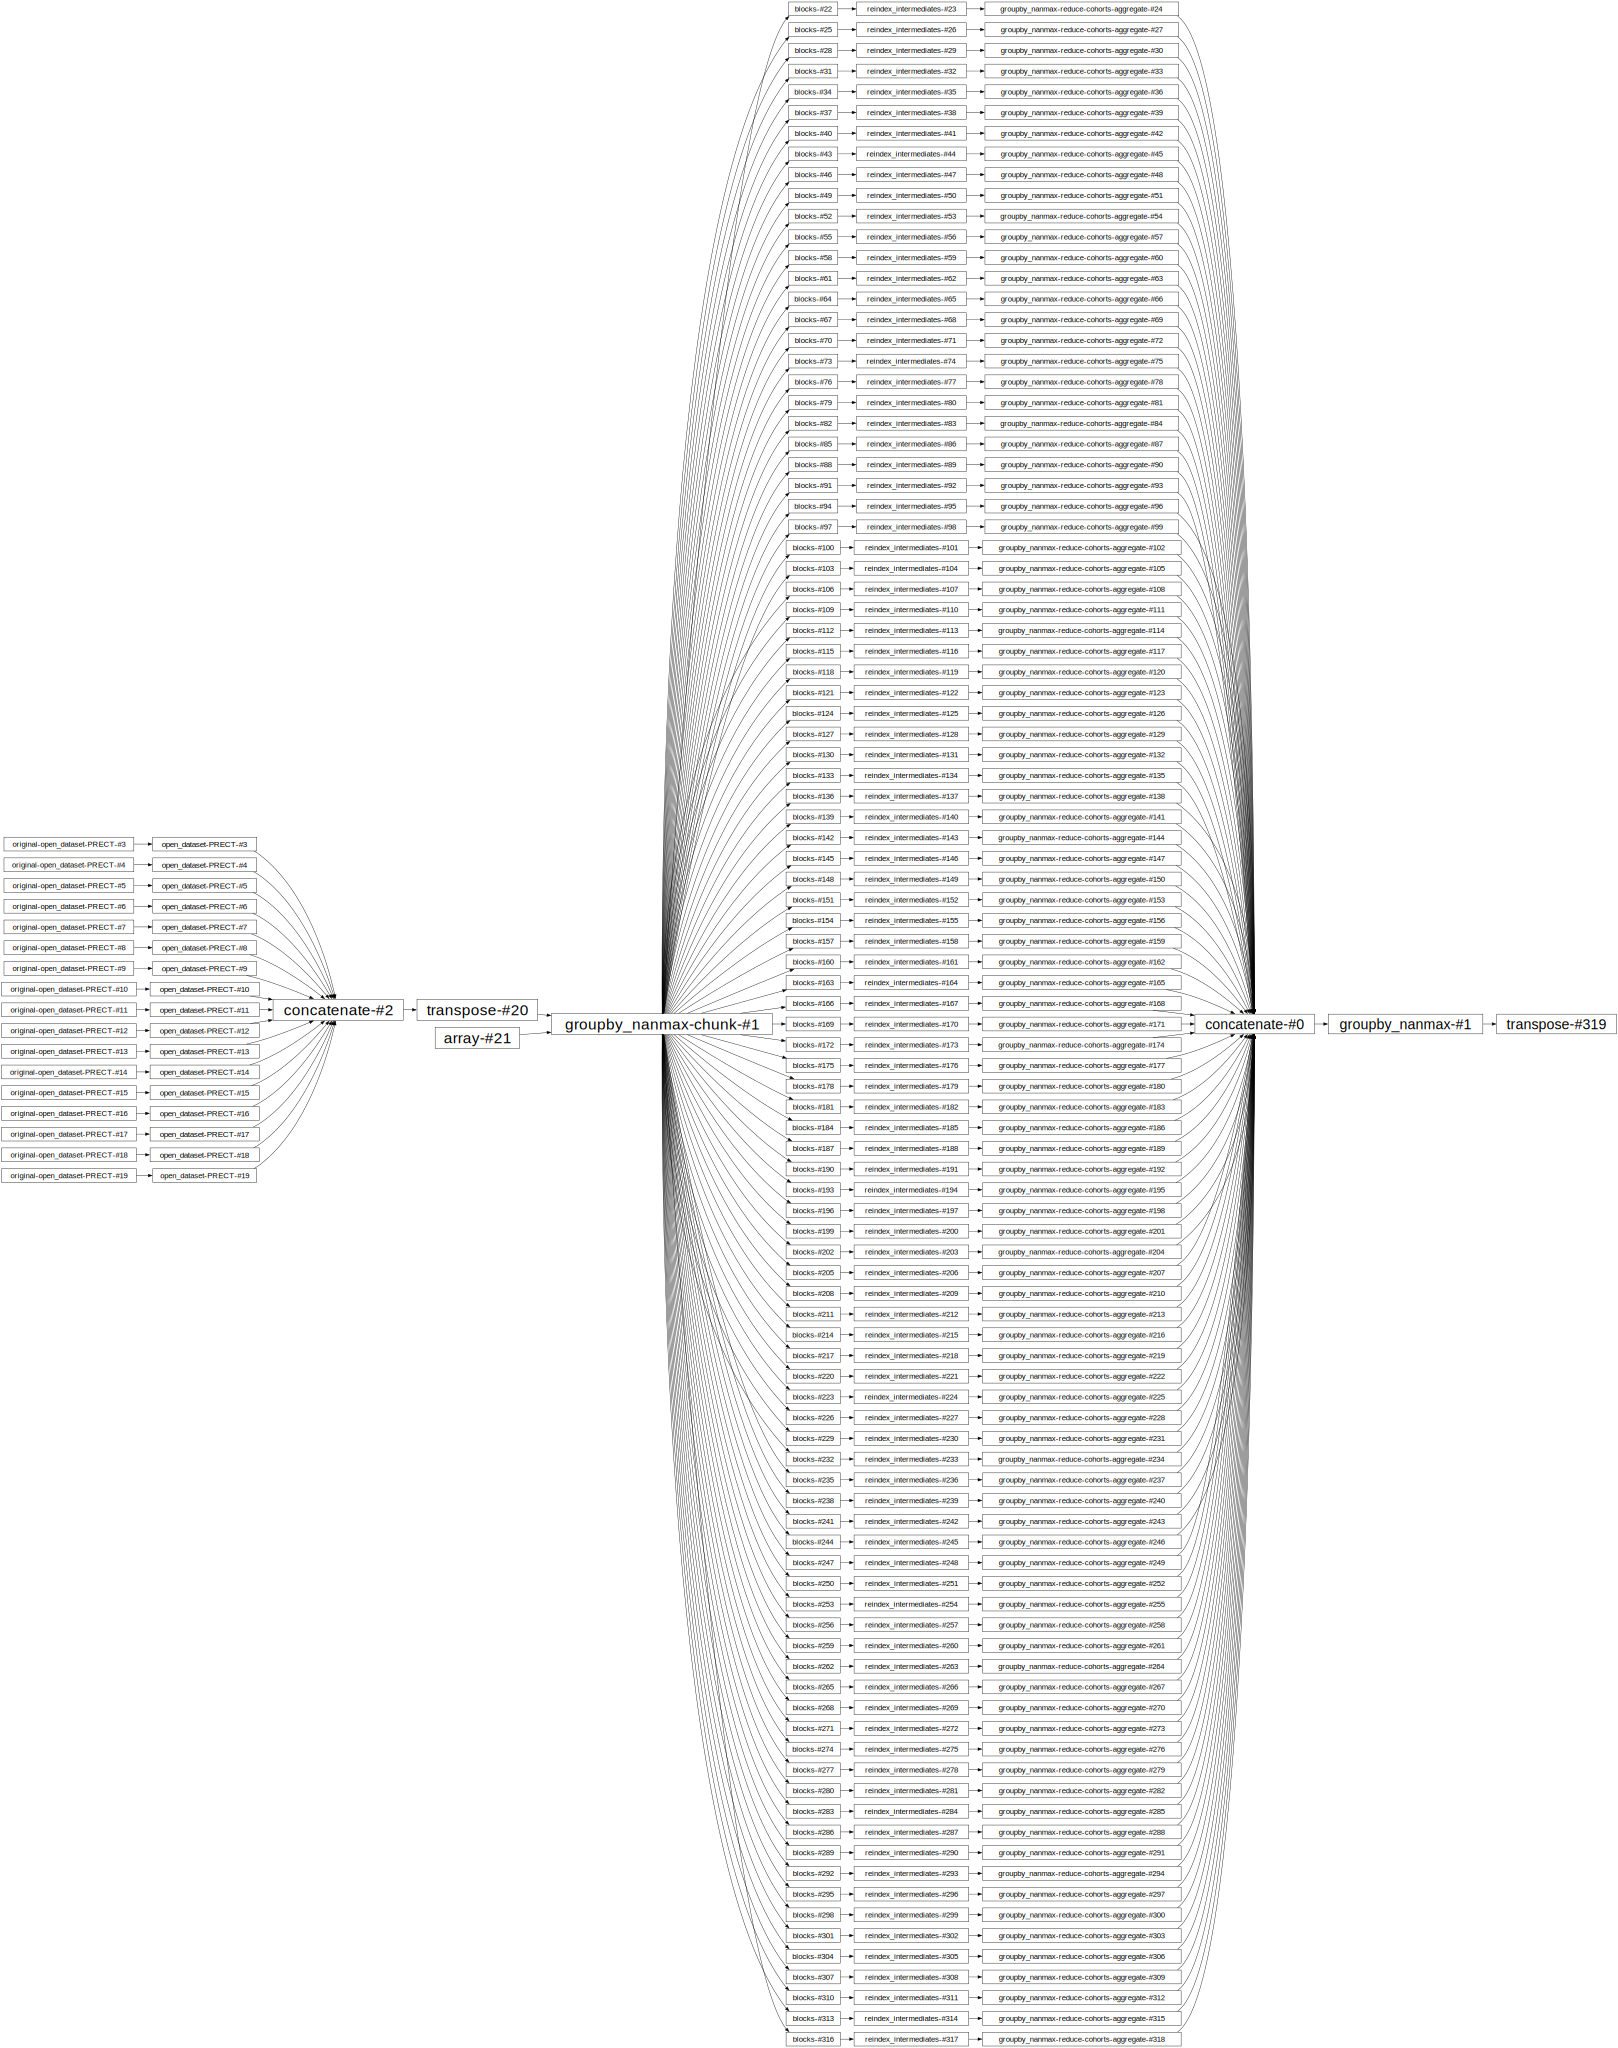

In [19]:
max_precip.data.dask.visualize(rankdir='LR')

## Now you want to to calculate maximum temperature:

In [20]:
%%time
## check out the dashboard:
save_precip = max_precip.compute()

CPU times: user 1.86 s, sys: 260 ms, total: 2.12 s
Wall time: 38.5 s


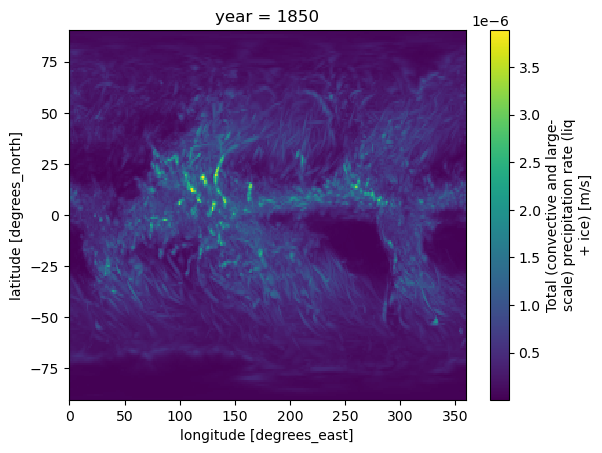

In [25]:
save_precip.sel(year=1850).plot()

### Note how this took longer than when I directly plotted max_precip.sel(year=2015).plot()

## Find 95% preciptation

In [58]:
qt_dims = ("lat","lon")
qt_values = 0.95



threshhold = precip.quantile(qt_values, dim=qt_dims, skipna=False)
threshhold

<xarray.DataArray 'PRECT' (time: 60226)> Size: 482kB
dask.array<getitem, shape=(60226,), dtype=float64, chunksize=(606,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 482kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
    quantile  float64 8B 0.95

In [59]:
threshhold = threshhold.compute()

In [61]:
precip_masked = precip.where(precip>threshhold)

### Plot all wet points where precip is > threshhold for first timestep

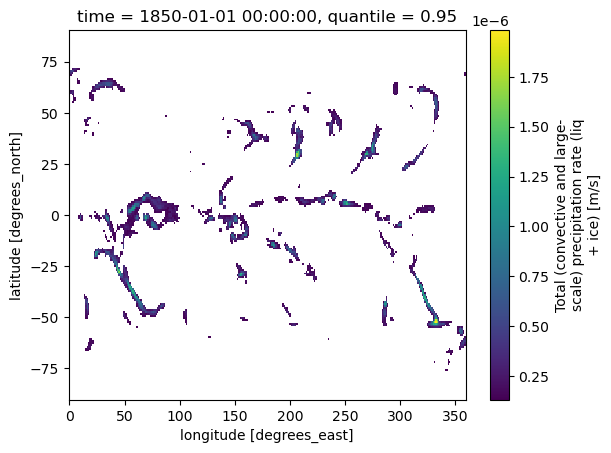

In [65]:
precip_masked.isel(time=0).plot()

## Another More Complex Analaysis -- 95% percentile of precip for each point at each year

In [69]:
#rechunking -- expensive but necessary here...
precip_2 = precip.chunk({"time": -1, "lat": "auto", "lon": "auto"})
precip_2

<xarray.DataArray 'PRECT' (time: 60226, lat: 192, lon: 288)> Size: 13GB
dask.array<rechunk-merge, shape=(60226, 192, 288), dtype=float32, chunksize=(60226, 19, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 482kB 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         m/s
    long_name:     Total (convective and large-scale) precipitation rate (liq...
    cell_methods:  time: mean

In [72]:
def quantile_calc(da, dim,perc=.95):
    """Calculates quantile"""
    return (da.quantile(q=perc, dim=dim,skipna=False))

# 95% percentile for each point at each year
threshhold2 = precip_2.groupby("time.year").map(quantile_calc, dim="time",perc=0.95)
threshhold2

<xarray.DataArray 'PRECT' (year: 166, lat: 192, lon: 288)> Size: 73MB
dask.array<concatenate, shape=(166, 192, 288), dtype=float64, chunksize=(1, 19, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B 0.95
  * year      (year) int64 1kB 1850 1851 1852 1853 1854 ... 2012 2013 2014 2015

In [71]:
%%time
threshhold2 = threshhold2.compute()

CPU times: user 43.9 s, sys: 616 ms, total: 44.6 s
Wall time: 52.4 s


### How about each month? 

In [73]:
monthly_95 = precip_2.groupby("time.month").map(quantile_calc, dim="time",perc=0.95)
monthly_95

<xarray.DataArray 'PRECT' (month: 12, lat: 192, lon: 288)> Size: 5MB
dask.array<concatenate, shape=(12, 192, 288), dtype=float64, chunksize=(1, 19, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat       (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    quantile  float64 8B 0.95
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12